1.
    Las magnitudes traidas de la parte anterior estan en los filtros f555w y f814w del HRC, se necesita transformar estos a los filtros V e I respectivamente. Para ello se pueden usar las constantes, fórmulas y constantes dadas en Sirianni et al 2015.

Siguiendo el procedimiento de la publicación mencionada, el primer paso será sustraer los zeropoints y otras correcciones que añadimos en la parte 1.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import isochrones

mags=np.loadtxt("mag.txt")

f5=mags[0]-25.255+0.056+0.656
f8=mags[1]-24.849+0.103+0.534



/home/zapredfield/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Luego usando las fórmulas y constantes dadas en las tablas, que tienen la forma:

$$m_{V/I}=m_{f555w/f814w} + c_0 +c_1 \cdot (V-I) + c_2 \cdot (V-I)^2$$

Se itera a partir de un valor inicial hasta encontrar los valores reales de V e I.

Lo hecho en el codigo de abajo es, dar a las magnitudes iniciales $m_{V,I}$ simplemente el valor de las magnitudes $m_{f555w,f814w}$. Luego se entrega esto a las fórmulas, obteniendo nuevos valores V e I, estos se ingresan a las fórmulas otra vez y así sucesivamente hasta que V e I convergan. Esto tomo solo unas 12 iteraciones.


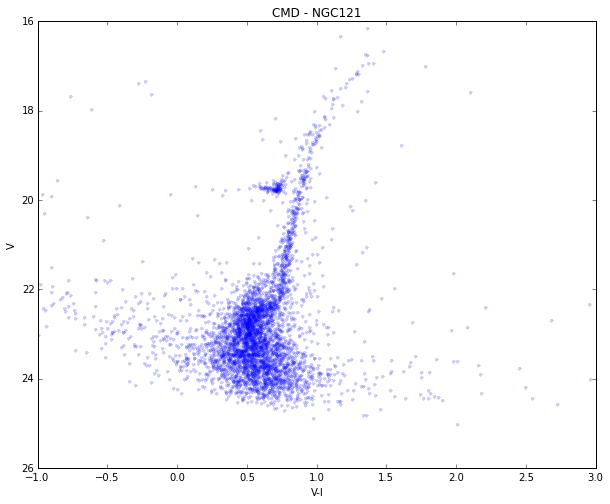

In [2]:

Vs=[]
Is=[]
VIs=[]


for j in range(0,len(f5)):
    f555=f5[j]
    f814=f8[j]
    V=f5[j]
    I=f8[j]
    VI=V-I
    
    for i in range(0,12):
        i=i+1

        if VI<0.6:
            V=f555+25.25-0.09*VI+0.034*VI**2

        if VI>0.6:
            V=f555+25.275-0.124*VI+0.018*VI**2        

        if VI<0.1:
            I=f814+24.837+0.06*VI-0.099*VI**2    

        if VI>0.1:
            I=f814+24.838+0.001*VI+0.013*VI**2        

        VI=V-I
    Vs.append(V-0.5) ###Para que calze la rama horizontal con literatura
    Is.append(I)
    VIs.append(VI)
    
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 8)
ax = plt.gca()
plt.xlim(-1,3)
ax.invert_yaxis()

plt.plot(VIs,Vs,".",alpha=0.2)
plt.title("CMD - NGC121")
plt.xlabel("V-I")
plt.ylabel("V")
plt.show()






Arriba esta la transformación obtenida.

A continuación un diagrama de Hess, el cual muestra la densidad de estrellas en cada sector. Notar que hay una densidad alta en la rama horizontal.

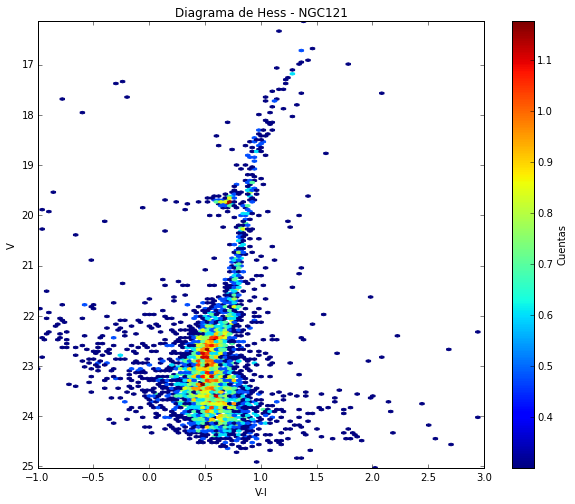

In [3]:

plt.rcParams['figure.figsize'] = (10, 8)
plt.hexbin(VIs,Vs,gridsize=200,bins='log',mincnt=1)
plt.xlim(-1,3)
leg1=plt.colorbar()
leg1.set_label('Cuentas')

ax = plt.gca()

ax.invert_yaxis()
plt.title("Diagrama de Hess - NGC121")
plt.xlabel("V-I")
plt.ylabel("V")
plt.show()

3.
    El siguiente paso fue trazar la ridge-line, para ello se usaron las filas como bins (25 bins) de grosor dy=0.26. Luego tomando las medianas de las posiciones V-I y V de cada dato se trazó la linea deseada.
    
Algunos procedimientos extra que tomar en cuenta:

La baja cantidad de bins, solo 25, se debe a que la densidad de puntos tampoco es muy alta, luego si se tomaba un número más alto quedaban saltos fuera de la CMD en la ridge-line.
    
Se utiliza la mediana debido a que existe un alto número de puntos fuera de la CMD, intentando minimizar el error.
    
También debido a la gran cantidad de puntos fuera de la CMD algunos se ignoraron a la hora de tomar la mediana.

Por último, para tener un mejor ajuste, se calibro el eje V con ramas horizontales tomadas de la literatura. 
    

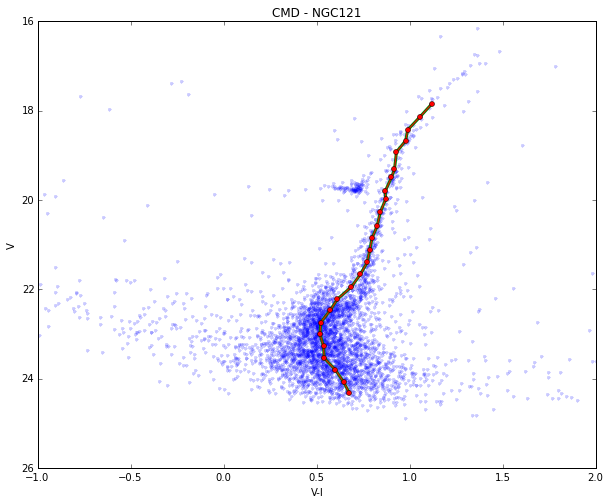

In [4]:

bins=np.linspace(24,17.5,25)
dy=bins[1]-bins[0]
puntos=[]


for i in range(0,len(Vs)):
    puntos.append((VIs[i],Vs[i]))

    
actualy=24.5


coords=[]

for i in bins:#cada linea
        cadabin=[]
        for punto in puntos:
            if punto[1]<=actualy and punto[1]>=actualy+dy:
                
                if punto[1]<=20.5 and punto[1]>=19.5:
                    if punto[0]>=0.8:
                        cadabin.append(punto)
                
                elif punto[0]>=0.2:
                    cadabin.append(punto)
        
        coords.append(cadabin)
        actualy=actualy+dy
            


losx=[]
losy=[]

for i in coords:
    x=[]
    y=[]
    for j in i:
        if len(i)>=1:
            x.append(j[0])
            y.append(j[1])
    losx.append(x)
    losy.append(y)

medianasx=[]
medianasy=[]

for i in range(0,len(losx)):
    medianax=np.median(losx[i])
    medianay=np.median(losy[i])
    medianasx.append(medianax)
    medianasy.append(medianay)


ax = plt.gca()
plt.xlim(-1,2)
ax.invert_yaxis()


plt.plot(VIs,Vs,".",alpha=0.2)
plt.plot(medianasx,medianasy,linewidth=3)
plt.plot(medianasx,medianasy,marker="o",markersize=5)
plt.title("CMD - NGC121")
plt.xlabel("V-I")
plt.ylabel("V")
plt.show()

A estos puntos se les ajustó una función cubica, este paso sera importante a la hora de encontrar la mejor isocrona posible.

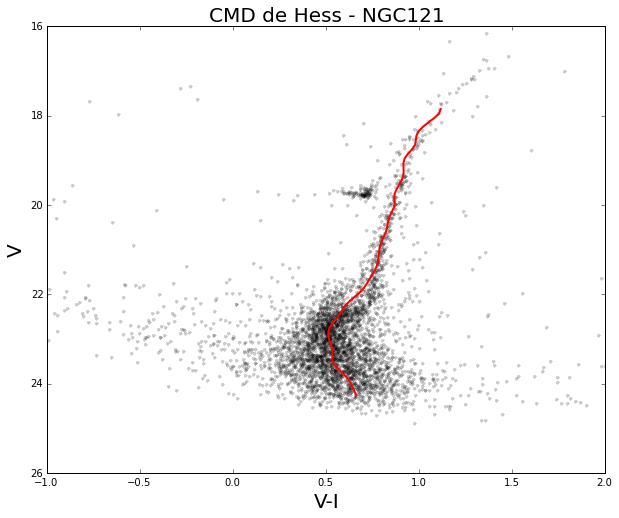

In [5]:
from scipy import interpolate
x = medianasx
y = medianasy
f = interpolate.interp1d(y, x,"cubic")



xnew = np.arange(np.min(y),np.max(y), 0.1)
ynew=f(xnew)


ax = plt.gca()
plt.xlim(-1,2)
ax.invert_yaxis()

plt.plot(VIs,Vs,".",color="k",alpha=0.2)
plt.plot(ynew, xnew, '-',color="r",linewidth=2)
plt.title("CMD de Hess - NGC121",size=20)
plt.xlabel("V-I",size=20)
plt.ylabel("V",size=20)
plt.show()


2

Ajustando una isocrona con los valores de la literatura, edad=$10.6\cdot 10^9 years$, [Fe/H]=-1.2 y modulo de distancia de 18.94 y con las extinciones y constante reddening-extincion tomadas de NED se obtuvo:


Datos tomados de Dolphin et al 2001 (http://arxiv.org/abs/astro-ph/0107164).


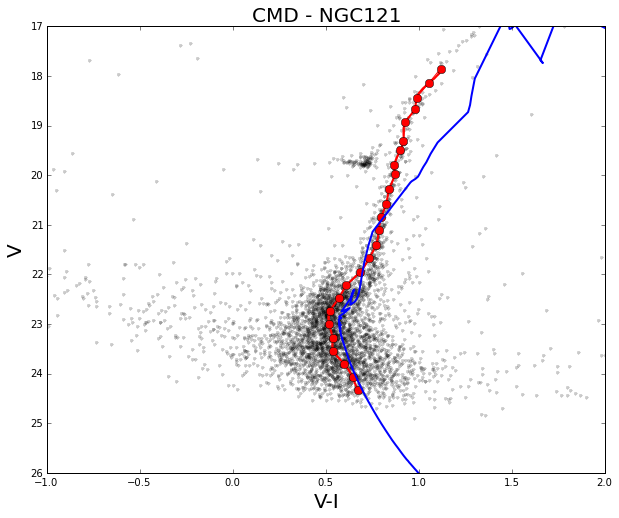

In [6]:
#ejemplo con datos de literatura:


from isochrones.dartmouth import Dartmouth_Isochrone

gyr=10.6*10**9
metal=-1.2
iso = Dartmouth_Isochrone(bands=['V','I'])
model = iso.isochrone(age=np.log10(gyr),feh=metal,dm=0.001)



model_i = model.I_mag
model_v = model.V_mag
# calculate B-V for this model
model_vi = model_v - model_i

model_v = model_v + 18.9

av=0.099
evi=av/3.1

model_v = model_v + av
model_vi = model_vi + evi

ax = plt.gca()

ax.invert_yaxis()
plt.xlim(-1,2)
plt.ylim(26,17)
plt.plot(VIs,Vs,".",color="k",alpha=0.2)
plt.plot(ynew, xnew, '-',color="r",linewidth=2)
plt.plot(medianasx,medianasy,color="r",marker="o",markersize=8)
plt.plot(model_vi,model_v,linewidth=2)
plt.title("CMD - NGC121",size=20)
plt.xlabel("V-I",size=20)
plt.ylabel("V",size=20)
plt.show()



Claramente que el ajuste entre la ridge-line y la isocrona no es muy buena, por lo que se debe considerar variar los valores de edad, metalicidad y modulo de distancia para así obtener un buen ajuste, esto se hará en la parte 4.

4

La idea de esta sección será encontrar los parametros (age,Fe/H,distance module) a partir de nuestros datos (ridge-line). Para ello se tomarán como valores iniciales los de la literatura y a estos se les añadirá una cantidad tomada de una distribución uniforme, de modo que variar los parametros. 

Con estos parametros "random" se obtendran isocronas, luego la isocrona que se ajuste mejor a la ridge-line debiese tener los parametros más cercanos a los reales.

Para saber cual se ajusta mejor se lleva a cabo un test de chi-cuadrado, usando la ecuación:
$$\chi ^2 = \sum  \frac{(isoc_i - ridge_i)^2}{ridge_i}  $$

Debido a que la ridge line la obtenemos de los datos iniciales, podemos llamar esta como el valor "esperado" y a las isocronas como "observado".

Luego el par de lineas que tengan el menor valor para $\chi ^2$ serán las con mejor ajuste.




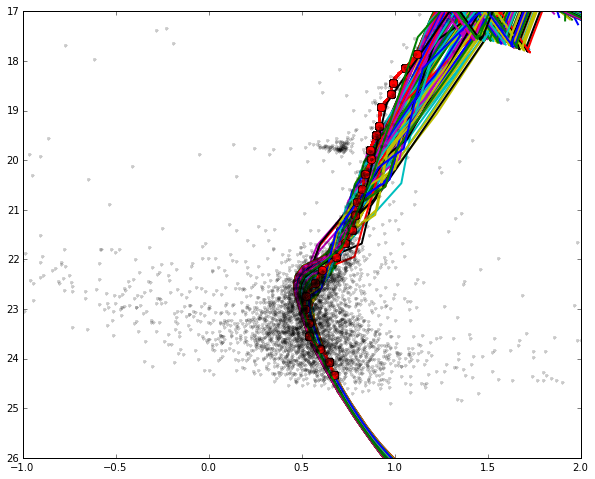

In [42]:
# Buscando el mejor ajuste:
import scipy.stats as sp


#valores de literatura que variaremos
distm=18.94
metal=-1.2
age=10.6*10**9

param=[]
chis=[]
iso = Dartmouth_Isochrone(bands=['V','I'])

x = medianasx
y = medianasy
f = interpolate.interp1d(y, x,"cubic")



xnew = np.arange(np.min(y),np.max(y), 0.1)
ynew=f(xnew)




def nums(modelo):
    x=[]
    for i in modelo:
        if i<10000:
            x.append(i)
    return x



for i in range(0,5):
    age=10.6*10**9
    age=age+np.random.uniform(-10.6**8,10.6**8)
    for j in range(0,20):
        metal=-1.5
        metal=metal+np.random.uniform(-0.5,0.5)
        param.append((age,metal))
        model = iso.isochrone(age=np.log10(age),feh=metal,dm=0.005)
        model_i = model.I_mag
        model_v = model.V_mag
        # calculate B-V for this model
        model_vi = model_v - model_i
        model_v = model_v + 18.94        
        mx=nums(model_vi)
        my=nums(model_v)        
        x = mx
        y = my
        f = interpolate.interp1d(y, x,"cubic")
        yn=f(xnew)
        #test chi
        x2=0
        for i in range(0,len(yn)):
            x2=x2+((yn[i]-ynew[i])**2)/ynew[i]
        chis.append(x2)
        #print x2
        #print(age,metal)


                
        
        #print (age,metal)
        
        
        
        
        ax = plt.gca()
        ax.invert_yaxis()
        plt.xlim(-1,2)
        plt.ylim(26,17)

        plt.plot(ynew, xnew, '-',color="r",linewidth=2)
        plt.plot(medianasx,medianasy,color="r",marker="o",markersize=8)
        plt.plot(model_vi,model_v,linewidth=2)

        
        
        
        
        
        
        
        
plt.plot(VIs,Vs,".",color="k",alpha=0.2)
plt.show()




        


Estas son todas las curvas creadas a partir de las 100 combinaciones de parametros, luego queremos obtener la que da un mejor ajuste.

Analizando varios resultados, se noto que la edad que da el mejor ajuste del punto de turn-off es alrededor de 10.4 Gyrs.

Edad: 10463748119.0 Fe/H: -1.64159868428
Chi-squared: 0.663558741756


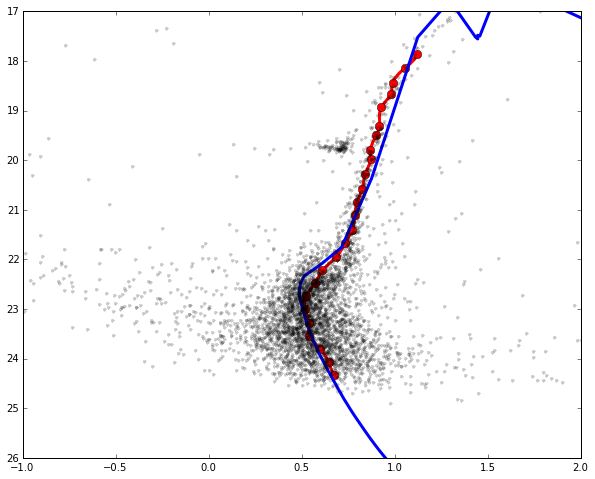

In [44]:
for i in range(0,len(chis)):
    if chis[i]==min(chis):
        index=i

p=param[i]
print "Edad:",p[0],"Fe/H:",p[1]
print "Chi-squared:",min(chis)
       
model = iso.isochrone(age=np.log10(p[0]),feh=p[1],dm=0.005)
model_i = model.I_mag
model_v = model.V_mag
# calculate B-V for this model
model_vi = model_v - model_i
model_v = model_v + 18.94   


ax = plt.gca()
ax.invert_yaxis()
plt.xlim(-1,2)
plt.ylim(26,17)

plt.plot(ynew, xnew, '-',color="r",linewidth=3)
plt.plot(medianasx,medianasy,color="r",marker="o",markersize=8)
plt.plot(model_vi,model_v,linewidth=3)
plt.plot(VIs,Vs,".",color="k",alpha=0.2)
plt.show()



Lo cual ajusta mejor que con los valores de la literatura.

Para este caso los parametros fueron:

    Edad:$10.463\cdot 10^9 yrs$
    
    Metalicidad:[Fe/H]=-1.64
    
   El módulo de distancia se dejo constante en 18.94 ya que no modifica la forma de la curva sino que solo su altura en el eje V y resultados que incluian variación de este valor no entregaban mejoras notables.

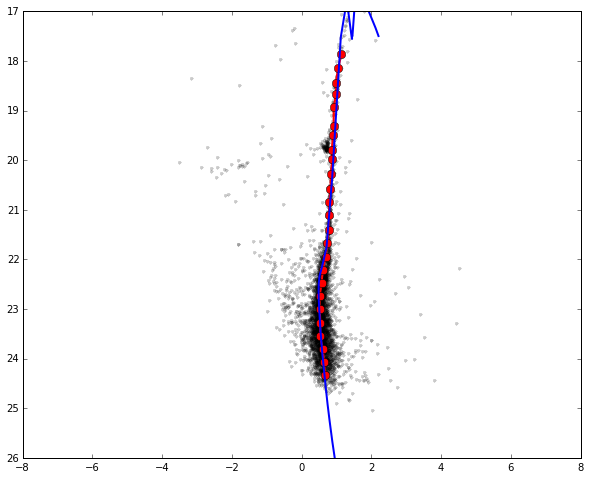

In [45]:
ax = plt.gca()

ax.invert_yaxis()
plt.xlim(-8,8)
plt.ylim(26,17)
plt.plot(VIs,Vs,".",color="k",alpha=0.2)
plt.plot(ynew, xnew, '-',color="r",linewidth=2)
plt.plot(medianasx,medianasy,color="r",marker="o",markersize=8)
plt.plot(model_vi,model_v,linewidth=2)
plt.show()